In [6]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from Utils.preprocessing import EcgDataset, ToTensor


transform = transforms.Compose([
    ToTensor(),
    transforms.Resize([64, 64])
    # transforms.Normalize(mean=[0.5], std=[0.5])
])

dataset = EcgDataset(
    root_dir="Data/training_data/dataset",
    transform=transform
)

train_data, val_data = random_split(dataset, [0.8,0.2])

train_loader = DataLoader(
    train_data,
    batch_size=64,
    shuffle=True
)
val_loader = DataLoader(
    val_data,
    batch_size=64,
    shuffle=True
)

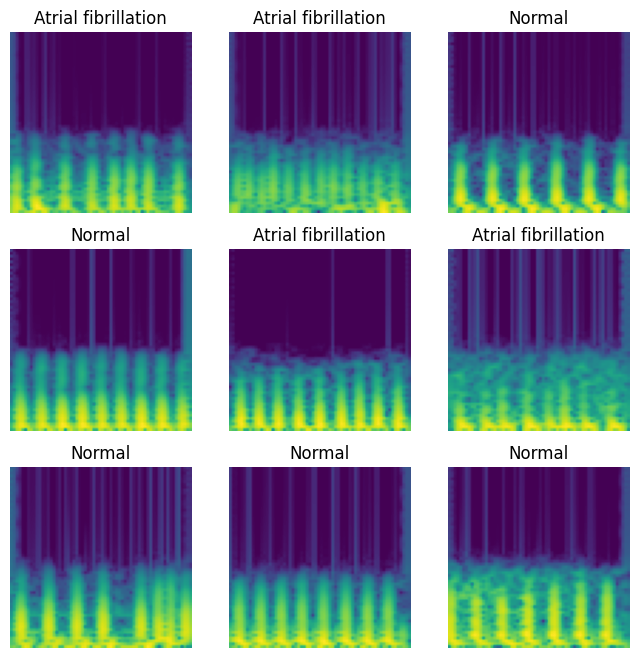

In [10]:
labels_map = {
    0: "Normal",
    1: "Atrial fibrillation"
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    # print(sample_idx)
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="viridis")
plt.show()

In [3]:
from torchsummary import summary
from Network.afib_detector_v1_0 import AfibDetector

net = AfibDetector()

if torch.cuda.is_available():
    net.cuda()

summary(net, (1,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 60, 60]             416
              ReLU-2           [-1, 16, 60, 60]               0
         MaxPool2d-3           [-1, 16, 30, 30]               0
            Conv2d-4           [-1, 32, 28, 28]           4,640
              ReLU-5           [-1, 32, 28, 28]               0
         MaxPool2d-6           [-1, 32, 14, 14]               0
            Conv2d-7           [-1, 64, 12, 12]          18,496
              ReLU-8           [-1, 64, 12, 12]               0
         MaxPool2d-9             [-1, 64, 6, 6]               0
          Dropout-10                 [-1, 2304]               0
           Linear-11                   [-1, 64]         147,520
             ReLU-12                   [-1, 64]               0
           Linear-13                    [-1, 2]             130
          Softmax-14                   

In [4]:
import torch.nn as nn
from torch import optim
from Utils.model_trainer import ModelTrainer
import os

MODEL_PATH = "./Models/afib_detector_v1_1_0/afib_detector_v1_1_0"
if not os.path.exists(os.path.dirname(MODEL_PATH)):
        os.makedirs(os.path.dirname(MODEL_PATH))

learning_rate = 0.005

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

#TODO
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.003)

epochs = 10
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

net.to(device)

modelTrainer = ModelTrainer(MODEL_PATH)

modelTrainer.train_model(
    net,
    train_loader,
    val_loader,
    loss_fn,
    optimizer,
    device,
    epochs
)

#TODO
# ModelTrainer.save_checkpoint(net.epoch, net, optimizer, "./Models/afib_detector_v0_1_checkpoint.pt")

# checkpoint = torch.load(CHECKPOINT_PATH)
# net.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# start_epoch = checkpoint['epoch']
# print(f"Resuming training from epoch {start_epoch}")

Device: cuda:0
EPOCH 1:
	batch 336 loss: 0.6910706464023817
	batch 672 loss: 0.6426505500539428
	batch 1008 loss: 0.5377076198125169
	batch 1344 loss: 0.4968714399174565
	batch 1680 loss: 0.48295130279092563
LOSS train 0.48295130279092563 valid 0.4559198908879468 ACCURACY 0.8605791926383972
EPOCH 2:
	batch 336 loss: 0.47730643151416663
	batch 672 loss: 0.46199683791824747
	batch 1008 loss: 0.4552706187324865
	batch 1344 loss: 0.4423527605831623
	batch 1680 loss: 0.43366358216319767
LOSS train 0.43366358216319767 valid 0.4224136966566009 ACCURACY 0.8917722702026367
EPOCH 3:
	batch 336 loss: 0.4329366150001685
	batch 672 loss: 0.427411212364123
	batch 1008 loss: 0.43149232323325815
	batch 1344 loss: 0.42504288779482957
	batch 1680 loss: 0.41617567979154135
LOSS train 0.41617567979154135 valid 0.4056751166698202 ACCURACY 0.9069041013717651
EPOCH 4:
	batch 336 loss: 0.41466038682985873
	batch 672 loss: 0.4069356571528174
	batch 1008 loss: 0.3977114936957757
	batch 1344 loss: 0.390707416548